In [1]:
!pip install PyDrive

In [2]:
import tarfile
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
from matplotlib import pyplot
from __future__ import print_function, division
import glob
import numpy as np
import skimage
from matplotlib import pyplot
import pandas as pd
from skimage import io
import shutil
import csv
import matplotlib.pyplot as pt
import os
import cv2
import pickle
import random

# Mount Google Drive Here

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [21]:
%cd /content/drive/MyDrive/ML Project 2
!git pull 

/content/drive/MyDrive/ML Project 2


# Upload the data

In [5]:
download = drive.CreateFile({'id': '1LflgaEIFdmoVTIPvoH29UPjLucKF1WL0'})
download.GetContentFile('data.tar')

In [6]:
#@title # Extracting the files from .tar 
my_tar = tarfile.open('/content/data.tar')
my_tar.extractall('/content/data') # specify which folder to extract to
my_tar.close()

# Data Cropping + Preprocessing

In [23]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/ML Project 2/ml_project2/src')
from sound_processing import *

/content/sound_processing.py:28: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(sound_path[i])


[[  39   10  -21 ...  159  161  160]
 [ 189  172  155 ... -318 -346 -372]
 [ 157  151  142 ... -386 -360 -331]
 ...
 [-143 -150 -153 ...   94  105  112]
 [-294 -272 -266 ...  -93 -113 -126]
 [-185 -217 -246 ...  -92 -113 -131]] Pn P3 Ca 4000 26


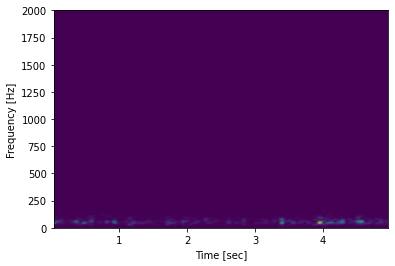

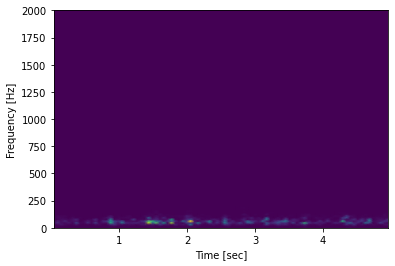

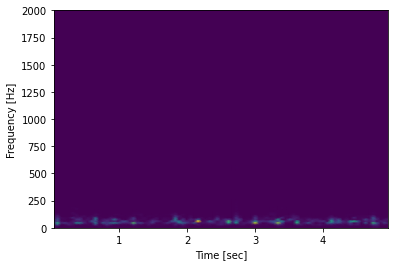

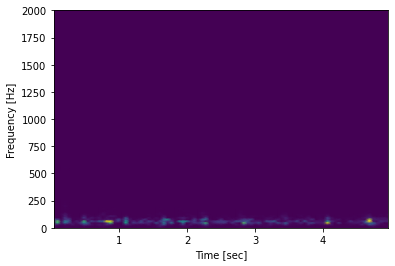

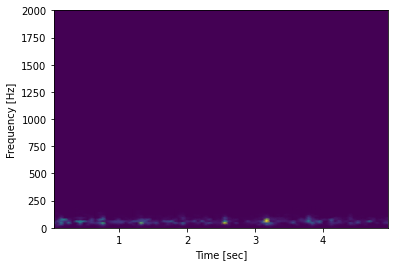

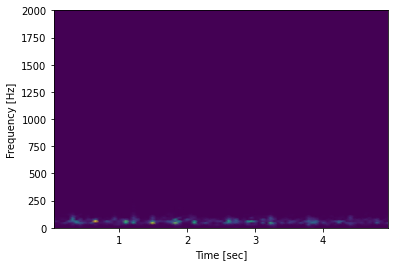

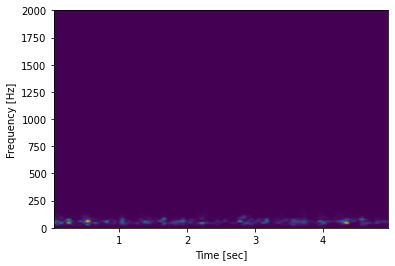

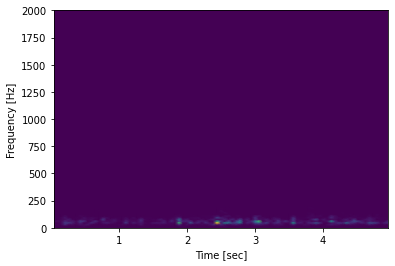

In [24]:
features, diseases, positions, controls, frequences, patientnbs = get_feature_and_labels( '/content/drive/MyDrive/ML Project 2/ml_project2/data/*/*/*/'  ) # both control and case

indx = 100 # example on sample nb100

print(features[indx] ,diseases[indx] , positions[indx] , controls[indx] , frequences[indx] , patientnbs[indx])

for sample in features[indx]:
    show_spec_from_sample(sample , frequences[indx])

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, ZeroPadding2D, Dropout, BatchNormalization, Activation
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, RemoteMonitor, TensorBoard, ReduceLROnPlateau
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

#Model

In [ ]:
#@title #Converts labels into categories
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)


In [ ]:
print(y_train)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://d8eaf5c0087e.ngrok.io


#Data Augmentation

In [ ]:
shape = X_train.shape[1:]
train_batch_size = 32
train_steps = X_train.shape[0]//train_batch_size # need to specify the number of steps since the data generator outputs continuously


x_test = X_test.astype('float32') # not sure why I do this but let's keep it for now
x_train = X_train.astype('float32')

train_generator = ImageDataGenerator(width_shift_range=4,
                            height_shift_range=4,
                            zoom_range=[1/1.3, 1.3],
                            )


train_generator.fit(x_train) #apply the augmetnation to train data

train_datagen = train_generator.flow(x_train, y_train, batch_size=train_batch_size) # creates the mii batch flow



#Model

In [ ]:
model = Sequential()

model.add(Convolution2D(20, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Convolution2D(50, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.004, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])


#Callbacks

checkpointer = ModelCheckpoint(monitor='val_loss', # automatically saves the model 
                               mode='auto', 
                               filepath='/content/drive/MyDrive/ML Project 2/Model/test_model.h5',
                               verbose=1,
                               save_best_only=True,
                               save_freq = 2
                              )

csv_logger = CSVLogger('/content/drive/MyDrive/ML Project 2/Model/test_model.txt') # saves the output log in csv


#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, # can be used to reduce the learning rate once the model stops learning
                       #min_delta=0.001, cooldown=1,
                       #verbose=1, patience=10,
                       # min_lr=4.0e-5)

#FitTheModel

history = model.fit_generator(train_datagen,
                              steps_per_epoch=train_steps,
                              epochs=600,
                              validation_data=(x_test, y_test),
                              callbacks=[checkpointer, verbose=True,
                              csv_logger,
                              TensorBoardColabCallback(tbc)])
                              
                              

SyntaxError: ignored